# **LSTM Implementation**
*This notebook processes data provided by the [IBM Call for Code Wildfire Challenge](https://community.ibm.com/community/user/datascience/blogs/susan-malaika/2020/11/10/call-for-code-spot-challenge-for-wildfires). The unpreprocessed data is available [on GitHub](https://github.com/Call-for-Code/Spot-Challenge-Wildfires).*

The notebook consists of the following process steps:

*   loading preprocessed data and weather forecast
*   generating sequencial data and normalize
*   split data into training, validation and testing data
*   training the LSTM Model
*   generate predictions on validation and testing data
*   get feature importance
*   plot result

In [ ]:
!pip install lime

import os
import numpy as np
import pandas as pd
import time
import random
import pickle
import tensorflow as tf
import keras
import math

from datetime import datetime, timedelta
from google.colab import drive
from collections import deque

from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization
from tensorflow.keras.callbacks import TensorBoard

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from lime import lime_tabular

     |████████████████████████████████| 275 kB 9.8 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=0d5773716a0741843de19f0aa2a585b3fb8005e8fe9b6bbfd3497fc17885822e
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


*   loading preprocessed data and weather forecast

In [ ]:
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/Wildfire_Challenge/Data')

df_all = pd.read_csv('Cleansed_Data.csv')
df_all['Date'] = pd.to_datetime(df_all['Date'])

first_col = df_all.pop('Estimated_fire_area')
df_all.insert(0, 'Estimated_fire_area', first_col)

df = df_all.drop(columns=['Mean_estimated_fire_brightness', 'Mean_estimated_fire_radiative_power'], inplace=False)
df = df.sort_values(['Region', 'Date'], ascending = [True, True])
df.set_index(['Region', 'Date'], inplace=True)
df.reset_index(inplace=True)

df.replace(['NSW','NT','QL','SA','TA','VI','WA'],[0.1,0.2,0.3,0.4,0.5,0.6,0.7], inplace=True)

Mounted at /content/drive


In [ ]:
SEQ_LEN = 70
scaler = MinMaxScaler()
FUTURE_PERIOD_PREDICT = 1
EPOCHS = 500
BATCH_SIZE = 40
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"

*   generating sequencial data and normalize

In [ ]:
def get_seq_data(df):
  preprocessed_df = df.drop(columns=['Date'], inplace=False)

  col = preprocessed_df.pop('Estimated_fire_area')
  preprocessed_df.insert(preprocessed_df.shape[1], 'Estimated_fire_area', col)

  for col in preprocessed_df.columns:
    if col not in ['Estimated_fire_area', 'Region', 'Date']:
      preprocessed_df[[col]] = scaler.fit_transform(preprocessed_df[[col]])

  sequential_data = []
  for region in [0.1,0.2,0.3,0.4,0.5,0.6,0.7]:

    df_region = preprocessed_df[preprocessed_df['Region'] == region]

    prev_days = deque(maxlen=SEQ_LEN) # These will be our actual sequences. They are made with deque, which keeps the maximum length by popping out older values as new ones come in

    for i in df_region.values:  # iterate over the values
      prev_days.append([n for n in i[:]])  # store all but the target
      if len(prev_days) == SEQ_LEN:
        sequential_data.append([np.array(prev_days), i[-1]])
  return sequential_data

splitting_date = pd.to_datetime('2021-01-17')-timedelta(days=SEQ_LEN)

sequential_data = get_seq_data(df.where(df.Date < '2021-01-17').dropna())
test_data = get_seq_data(df.where(df.Date >= splitting_date).dropna())

* split into training, validation and testing data

In [ ]:
rng = np.random.default_rng()
rng.shuffle(sequential_data)

train_data, val_data = np.split(sequential_data,[int(0.9 * len(sequential_data))])

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [ ]:
def split_x_and_y(data):
  X = []
  y = []

  for seq, Estimated_fire_area in data:  # going over our new sequential data
    X.append(seq[:,:40])  # X is the sequences
    y.append(Estimated_fire_area)  # y is the targets/labels
  return np.asarray(X), np.asarray(y)
  
train_x, train_y = split_x_and_y(train_data)
validation_x, validation_y = split_x_and_y(val_data)
test_x, test_y = split_x_and_y(test_data)

*   training the LSTM Model

In [ ]:
model = Sequential()
model.add(LSTM(70, input_shape=train_x.shape[1:], activation="tanh", return_sequences=True))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(LSTM(100, input_shape=train_x.shape[1:], activation="tanh", return_sequences=True))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(LSTM(100, input_shape=train_x.shape[1:], activation="tanh"))
model.add(Dropout(0.1))
model.add(BatchNormalization())

model.add(Dense(FUTURE_PERIOD_PREDICT, activation="relu"))

opt = tf.keras.optimizers.Adam(learning_rate=0.001, decay=1e-6)

model.compile(loss='mean_squared_error',
              optimizer=opt,
              metrics=['mse']
)

filepath = "RNN_Final-{epoch:02d}-{val_loss:.3f}"

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(validation_x, validation_y)
)

# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)

# Save model
model.save("models/{}".format(NAME))

Epoch 1/500
912/912 [==============================] - 17s 14ms/step - loss: 9896.7949 - mse: 9896.7949 - val_loss: 5626.0830 - val_mse: 5626.0830
Epoch 2/500
912/912 [==============================] - 12s 13ms/step - loss: 5871.1514 - mse: 5871.1514 - val_loss: 5202.8794 - val_mse: 5202.8794
Epoch 3/500
912/912 [==============================] - 12s 13ms/step - loss: 5325.7598 - mse: 5325.7598 - val_loss: 7034.9653 - val_mse: 7034.9653
Epoch 4/500
912/912 [==============================] - 12s 13ms/step - loss: 5036.9282 - mse: 5036.9282 - val_loss: 5021.2305 - val_mse: 5021.2305
Epoch 5/500
912/912 [==============================] - 12s 13ms/step - loss: 4743.3950 - mse: 4743.3955 - val_loss: 4438.3745 - val_mse: 4438.3745
Epoch 6/500
912/912 [==============================] - 12s 13ms/step - loss: 4523.8521 - mse: 4523.8521 - val_loss: 4438.1055 - val_mse: 4438.1055
Epoch 7/500
912/912 [==============================] - 12s 13ms/step - loss: 4216.2354 - mse: 4216.2354 - val_loss: 39

INFO:tensorflow:Assets written to: models/70-SEQ-1-PRED-1630492717/assets


INFO:tensorflow:Assets written to: models/70-SEQ-1-PRED-1630492717/assets


In [ ]:
## reload model
#model = keras.models.load_model("models/{}".format('70-SEQ-1-PRED-1628505469'))

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 70, 70)            31080     
_________________________________________________________________
dropout_3 (Dropout)          (None, 70, 70)            0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 70, 70)            280       
_________________________________________________________________
lstm_4 (LSTM)                (None, 70, 100)           68400     
_________________________________________________________________
dropout_4 (Dropout)          (None, 70, 100)           0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 70, 100)           400       
_________________________________________________________________
lstm_5 (LSTM)                (None, 100)              

*   generate predictions on validation data

In [ ]:
def get_prediction(x, actual):
  prediction = model.predict(x)
  result_df = pd.DataFrame(actual, columns = ["ACTUAL"])
  result_df.insert(value = prediction, column = "PREDICTIONS", loc = 0)
  result_df['DIFFERENCE'] = result_df.PREDICTIONS - result_df.ACTUAL
  result_df.dropna(inplace=True)

  print('ACCURACY RESULTS')
  print('Root Mean Squared Error:',round(math.sqrt(mean_squared_error(np.asarray(result_df.ACTUAL), np.asarray(result_df.PREDICTIONS), squared=False)),2))
  print('R2 Score:',round(r2_score(np.asarray(result_df.ACTUAL), np.asarray(result_df.PREDICTIONS)),2))
  print("")
 
  print(result_df.head(5))
  print('...')
  print(result_df.tail(5))
  print('_______________________________')
  return result_df

validation_df = get_prediction(validation_x, validation_y)
test_df = get_prediction(test_x, test_y)

ACCURACY RESULTS
Root Mean Squared Error: 5.91
R2 Score: 0.92

   PREDICTIONS      ACTUAL  DIFFERENCE
0   263.024872  252.562689   10.462183
1     0.000000    3.360000   -3.360000
2     0.000000    0.000000    0.000000
3    63.246067   75.355217  -12.109150
4   459.723145  457.412692    2.310452
...
      PREDICTIONS      ACTUAL  DIFFERENCE
4048     0.000000    8.960000   -8.960000
4049   422.092377  359.965684   62.126693
4050     0.000000    0.000000    0.000000
4051    86.054344   10.292000   75.762344
4052     0.000000    0.000000    0.000000
_______________________________
ACCURACY RESULTS
Root Mean Squared Error: 5.27
R2 Score: 0.04

   PREDICTIONS  ACTUAL  DIFFERENCE
0          0.0  11.160     -11.160
1          0.0   5.000      -5.000
2          0.0   3.840      -3.840
3          0.0   6.075      -6.075
4          0.0   8.700      -8.700
...
     PREDICTIONS  ACTUAL  DIFFERENCE
107     5.962535   2.640    3.322535
108     0.000000  13.824  -13.824000
109     0.000000   0.000   

In [ ]:
test_df.reset_index(inplace=True)

for region in ['NSW', 'VI', 'TA', 'SA', 'NT', 'QL', 'WA']:
  df_reg = test_df[test_df['Region'] == region].set_index(['Date'],inplace=False)
  print('Region:', region ,', Root Mean Squared Error:',round(math.sqrt(mean_squared_error(np.asarray(df_reg.ACTUAL), np.asarray(df_reg.PREDICTIONS), squared=False)),2))

Region: NSW , Root Mean Squared Error: 3.9
Region: VI , Root Mean Squared Error: 0.94
Region: TA , Root Mean Squared Error: 0.5
Region: SA , Root Mean Squared Error: 1.99
Region: NT , Root Mean Squared Error: 2.97
Region: QL , Root Mean Squared Error: 4.52
Region: WA , Root Mean Squared Error: 8.26


*   get feature importance

In [ ]:
feature_df = df.drop(columns=['Date', 'Estimated_fire_area'], inplace=False)
feature_df = feature_df.rename(columns=
                               {'Precipitation_Max': 'Prec_Max', 
                                'Precipitation_Mean':'Prec_Mean',
                                'Precipitation_Min':'Prec_Min',
                                'Precipitation_Variance':'Prec_Var',
                                'RelativeHumidity_Max': 'RelHum_Max', 
                                'RelativeHumidity_Mean': 'RelHum_Mean', 
                                'RelativeHumidity_Min': 'RelHum_Min', 
                                'RelativeHumidity_Variance': 'RelHum_Var', 
                                'SoilWaterContent_Max': 'SoilWater_Max',
                                'SoilWaterContent_Mean': 'SoilWater_Mean',
                                'SoilWaterContent_Min': 'SoilWater_Min',
                                'SoilWaterContent_Variance': 'SoilWater_Var',
                                'SolarRadiation_Max': 'SolRad_Max',
                                'SolarRadiation_Mean': 'SolarRad_Mean', 
                                'SolarRadiation_Min': 'SolarRad_Min', 
                                'SolarRadiation_Variance': 'SolarRad_Var',
                                'Temperature_Max': 'T_Max',
                                'Temperature_Mean': 'T_Mean',
                                'Temperature_Min': 'T_Min',
                                'Temperature_Variance': 'T_Var',
                                'WindSpeed_Max': 'WS_Max',
                                'WindSpeed_Mean': 'WS_Mean',
                                'WindSpeed_Min': 'WS_Min',
                                'WindSpeed_Variance': 'WS_Var',
                                'Vegetation_index_mean': 'VegInd_Mean',
                                'Vegetation_index_max': 'VegInd_Max',
                                'Vegetation_index_min': 'VegInd_Min',
                                'Vegetation_index_std': 'VegInd_Std',
                                'Vegetation_index_variance': 'VegInd_Var',
                                'Shrubs_inflame_risk': 'Shrubs_IR',
                                'Herbaceous vegetation_inflame_risk': 'Herb_IR',
                                'Cultivated and managed vegetation/agriculture (cropland)_inflame_risk"': 'Crop_IR',
                                'Herbaceous wetland_inflame_risk': 'HerbWet_IT',
                                'Closed forest, deciduous broad leaf_inflame_risk': 'CD_IR',
                                'Closed forest, unknown_inflame_risk': 'CU_IR',
                                'Open forest, deciduous broad leaf_inflame_risk': 'OD_IR',
                                'Open forest, unknown definitions_inflame_risk': 'OU_IR'})
feature_names = feature_df.columns

explainer = lime_tabular.RecurrentTabularExplainer(train_x, 
                                                   training_labels=train_y,
                                                   feature_names=feature_names, 
                                                   mode='regression')

In [ ]:
exp = explainer.explain_instance(data_row=test_x[0].reshape(1, SEQ_LEN, 40),
                                 classifier_fn=model.predict, 
                                 num_features=40)

exp.show_in_notebook()

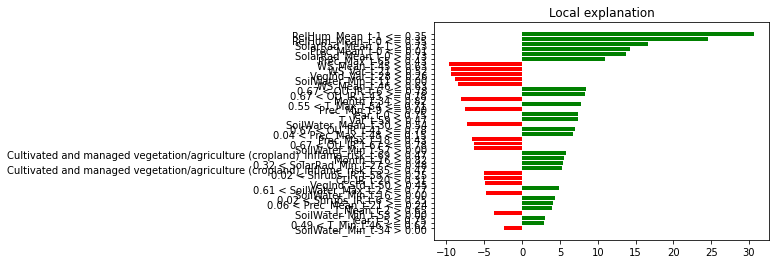

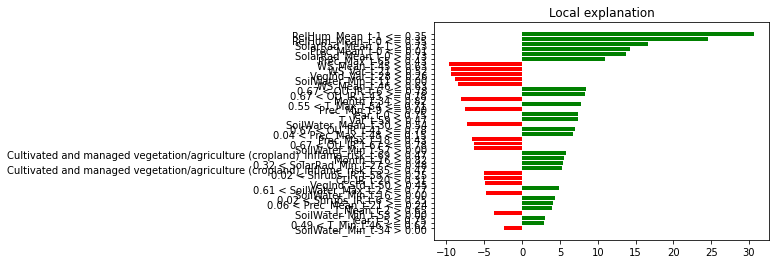

In [ ]:
exp.as_pyplot_figure()

*   plot result

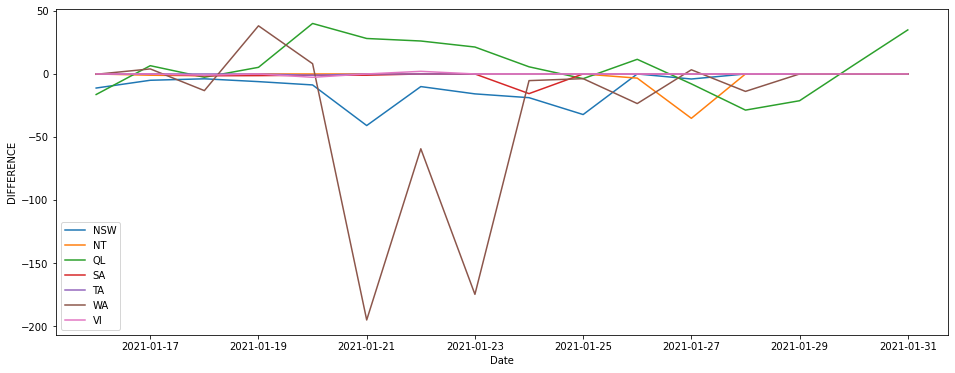

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
plt.figure(figsize=(16, 6))
g = sns.lineplot(x="Date", y="DIFFERENCE", hue='Region', data=test_df, hue_order=['NSW', 'NT', 'QL', 'SA', 'TA', 'WA', 'VI'])
plt.legend(loc='lower left')